Exploring similarities of DVs and clustering

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
from kneed import KneeLocator

print(os.getcwd())
# os.chdir('../')
# print(os.getcwd())

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1


Data prep

In [5]:

df = pd.read_csv('wbl_05_22_super_sabbatical_processed.csv')

df = df[['groupId',
 'playerId',
 'PostDiscussionGeneral_raw_discussionDepth',
 'PostDiscussionGeneral_raw_discussionDisagreement',
 'PostDiscussionGeneral_raw_discussionEnjoy',
 'PostDiscussionGeneral_raw_discussionTension',
 'PostDiscussionGeneral_raw_selfAnxious',
 'PostDiscussionGeneral_raw_selfInsight',
 'PostDiscussionGeneral_raw_selfLearned',
 'PostDiscussionGeneral_raw_selfSpeakUp',
 'PostDiscussionGeneral_raw_selfVoice',
 'PostDiscussionPerceptionOfOthers_raw_defensive',
 'PostDiscussionPerceptionOfOthers_raw_liking',
 'PostDiscussionPerceptionOfOthers_raw_partnerListening',
 'PostDiscussionPerceptionOfOthers_raw_partnerPerspectiveTaking',
 'PostDiscussionPerceptionOfOthers_raw_partnerTalking',
 'PostDiscussionPerceptionOfOthers_raw_polite',
 'PostDiscussionPerceptionOfOthers_raw_selfPerspectiveTaking',
 'deal_sheet_agreement_binary',
 'post_negotiation_conflict_1',
 'post_negotiation_conflict_2',
 'post_negotiation_conflict_3',
 'post_negotiation_conflict_4',
 'post_negotiation_decision_leadership_1',
 'post_negotiation_decision_leadership_2',
 'post_negotiation_goal_similarity',
 'post_negotiation_viability_1',
 'post_negotiation_viability_2',
 'role']]


df.columns = ['groupId',
 'playerId',
 'discussionDepth',
 'discussionDisagreement',
 'discussionEnjoy',
 'discussionTension',
 'selfAnxious',
 'selfInsight',
 'selfLearned',
 'selfSpeakUp',
 'selfVoice',
 'defensive',
 'liking',
 'partnerListening',
 'partnerPerspectiveTaking',
 'partnerTalking',
 'polite',
 'selfPerspectiveTaking',
 'agreement_binary',
 'conflict_1',
 'conflict_2',
 'conflict_3',
 'conflict_4',
 'decision_leadership_1',
 'decision_leadership_2',
 'goal_similarity',
 'viability_1',
 'viability_2',
 'role']



df['agreement_binary'] = df['agreement_binary'].map({'Yes': 1, 'No': 0})


list(df)


['groupId',
 'playerId',
 'discussionDepth',
 'discussionDisagreement',
 'discussionEnjoy',
 'discussionTension',
 'selfAnxious',
 'selfInsight',
 'selfLearned',
 'selfSpeakUp',
 'selfVoice',
 'defensive',
 'liking',
 'partnerListening',
 'partnerPerspectiveTaking',
 'partnerTalking',
 'polite',
 'selfPerspectiveTaking',
 'agreement_binary',
 'conflict_1',
 'conflict_2',
 'conflict_3',
 'conflict_4',
 'decision_leadership_1',
 'decision_leadership_2',
 'goal_similarity',
 'viability_1',
 'viability_2',
 'role']

In [12]:
def identify_principal_components(df, variables, max_components=None):
    # Drop rows with NaN values
    df = df.dropna(subset=variables)
    
    # Standardize the data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df[variables])
    
    # Perform PCA
    pca = PCA()
    pca.fit(standardized_data)
    
    # Determine the number of components to retain (explaining 95% variance or max_components)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    num_components = np.argmax(cumulative_variance >= 0.95) + 1
    if max_components:
        num_components = min(num_components, max_components)
    
    # Apply PCA with selected components
    pca = PCA(n_components=num_components)
    reduced_data = pca.fit_transform(standardized_data)
    
    # Identify variable groupings based on factor loadings
    loadings = pd.DataFrame(pca.components_.T, index=variables, columns=[f'PC{i+1}' for i in range(num_components)])
    print("PCA Factor Loadings:\n", loadings)
    
    # Display explained variance for each component and cumulative variance
    for i in range(min(3, len(explained_variance_ratio))):
        print(f"PC{i+1} explains: {explained_variance_ratio[i] * 100:.2f}%")
    print(f"Cumulative variance explained by the first {num_components} PCs: {cumulative_variance[num_components-1] * 100:.2f}%")
    
    return reduced_data, loadings, df, explained_variance_ratio, cumulative_variance

def perform_kmeans_clustering(reduced_data, df, variables, max_clusters=5):
    # Determine optimal number of clusters using the elbow method (max max_clusters)
    distortions = []
    K = range(1, max_clusters + 1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(reduced_data)
        distortions.append(sum(np.min(cdist(reduced_data, kmeans.cluster_centers_, 'euclidean'), axis=1)) / reduced_data.shape[0])
    
    # Use KneeLocator to find the optimal number of clusters
    kneedle = KneeLocator(K, distortions, curve="convex", direction="decreasing")
    optimal_k = kneedle.elbow
    print(f"Optimal number of clusters: {optimal_k}")
    
    # Plot the elbow method
    plt.figure(figsize=(8, 5))
    plt.plot(K, distortions, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal Clusters')
    if optimal_k is not None:
        plt.axvline(optimal_k, color='r', linestyle='--')
    plt.show()
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(reduced_data)
    df['Cluster'] = clusters

    # Identify most important variables for each cluster
    cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=[f'PC{i+1}' for i in range(reduced_data.shape[1])])
    important_features = {}
    
    for cluster_num in range(optimal_k):
        # Identify the principal component with the highest variance for the cluster center
        most_important_pc = cluster_centers.iloc[cluster_num].abs().idxmax()
        
        # Map the principal component back to original variables
        feature_importance = np.abs(df[variables].corrwith(df[most_important_pc]))
        top_features = feature_importance.nlargest(3).index.tolist()
        
        # Suggest an intuitive name based on the most important features
        cluster_name = " & ".join(top_features)
        important_features[cluster_num] = {
            "Cluster Name": cluster_name,
            "Important Features": top_features
        }
    
    # Reduce data to 2D using t-SNE for better visualization
    tsne = TSNE(n_components=2, random_state=42)
    tsne_data = tsne.fit_transform(reduced_data)
    
    # Plot the clusters using t-SNE
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=clusters, palette='viridis', s=50)
    
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('K-Means Clustering Results with t-SNE')
    plt.legend()
    plt.show()
    
    # Display cluster names and important features
    for cluster_num, details in important_features.items():
        print(f"Cluster {cluster_num}: {details['Cluster Name']} (Important Features: {', '.join(details['Important Features'])})")
    
    return df  # Return the full DataFrame with the added 'Cluster' column

# Example usage:
# reduced_data, pca, df = identify_principal_components(df, variables, max_components=3)
# result = perform_kmeans_clustering(reduced_data, df, variables, max_clusters=5)


In [9]:
df = df.dropna()
df['discussionTension'] = pd.to_numeric(df['discussionTension'].replace('1S', 1))
df['discussionTension'].unique()

array([4, 3, 2, 5, 1])

In [14]:

df_num = df.drop(['role', 'groupId', 'playerId'], axis=1)

reduced_data, loadings, df_pca, explained_variance_ratio, cumulative_variance = identify_principal_components(df_num, list(df_num), max_components=50)
print(explained_variance_ratio)
print(cumulative_variance)

loadings.to_csv('pca_loadings.csv')


PCA Factor Loadings:
                                PC1       PC2       PC3       PC4       PC5  \
discussionDepth           0.195886  0.327522 -0.119739  0.191386  0.072578   
discussionDisagreement   -0.133579  0.380583  0.037884  0.153195  0.241614   
discussionEnjoy           0.249810  0.183661 -0.104247  0.124546  0.070549   
discussionTension         0.255393 -0.086088 -0.070764  0.114850  0.036154   
selfAnxious              -0.165114  0.264533 -0.024874 -0.211033 -0.288155   
selfInsight               0.094758  0.284698 -0.261807  0.062227 -0.185464   
selfLearned              -0.072611 -0.042827 -0.057871  0.564261  0.048730   
selfSpeakUp               0.206241  0.196432 -0.043516  0.095635 -0.088511   
selfVoice                 0.105453 -0.171982 -0.202946  0.161179  0.529848   
defensive                -0.197128  0.304353 -0.177896  0.101500  0.079031   
liking                    0.268141  0.147431 -0.057698 -0.028575 -0.039280   
partnerListening          0.285595  0.0673

Optimal number of clusters: 3


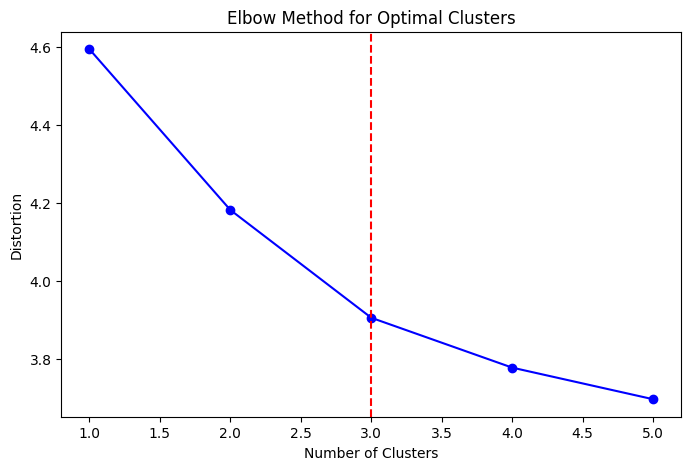

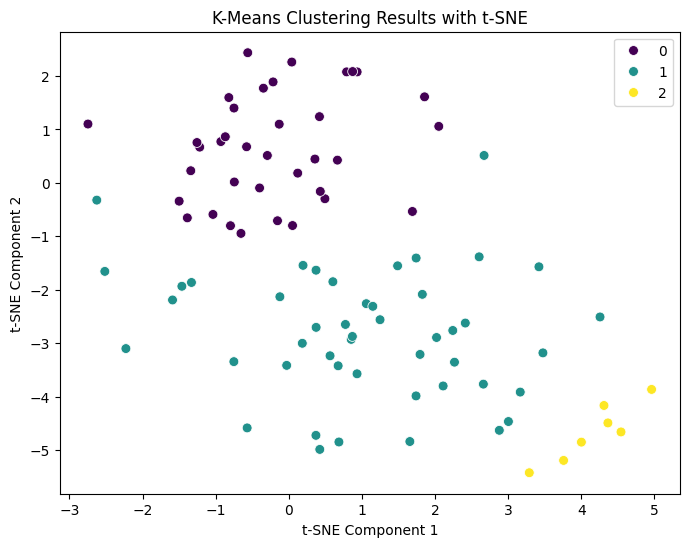

In [160]:
result = perform_kmeans_clustering(reduced_data, df_pca, max_clusters=5)